# T34 - Factors of success in abstract theoretical courses

Kalju Nekvasil, Edvin Martin Andrejev, Mihkel Hani, Jared Wildermuth

## Problem

Courses containing a lot of mathematics are traditionally hard for students. However, there are still some students who excel in them. The objective is to find out what these students do differently and whether there are activities or behavioural patterns that could be recommended to the other students to make such courses easier for them.

In [116]:
import csv
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.cluster import KMeans
from scipy.stats import linregress
from collections import defaultdict
from sklearn.decomposition import PCA
from datetime import datetime, timedelta
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import PartialDependenceDisplay
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, silhouette_score

## Making Sense of the Initial Data

We are given four datasets: two semesters of student grades and the students' activity logs. For simplicity, both semesters are merged so only two datasets have to be worked on. This should not have any negative affect as we can assume that the curriculum remained unchanged over both semesters.

In [117]:
grades = pd.read_csv("data/new/grades.csv")
crude_logs = pd.read_csv("data/original/activity_log_A(in).csv")

In [118]:
grades

,Student,Homework 1,Homework 2,Homework 3,Homework 4,Homework 5,Homework 6,Homework 7,Homework 8,Homework 9,Homework 10,Homework 11,Homework 12,Midterm exam,Final exam,Total,Grade
0,B001,-,-,-,-,-,-,-,-,-,-,-,-,0.0,0.0,0.0,-
1,B002,80.0,100.0,80.0,94.0,60.0,16.0,70.0,68.0,-,-,36.25,-,52.0,68.0,64.07,D
2,B003,100.0,100.0,100.0,110.0,90.0,110.0,100.0,65.0,110.0,110.0,110.0,105.0,82.0,0.0,87.37,B
3,B004,100.0,95.0,90.0,94.0,88.0,92.0,100.0,85.0,92.0,85.0,80.0,85.0,50.0,0.0,80.9,B
4,B005,90.0,100.0,110.0,97.0,95.0,92.0,75.0,100.0,38.0,55.0,60.0,100.0,90.0,0.0,91.47,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220,A102,110.0,80.0,60.0,-,-,-,45.0,85.0,-,-,-,-,0.0,0.0,6.33,-
221,A103,90.0,45.0,60.0,87.5,98.0,36.0,32.0,30.0,10.0,10.0,92.0,-,78.0,51.0,61.44,D
222,A104,90.0,95.0,100.0,82.5,89.0,36.0,-,-,-,-,48.0,-,83.0,75.0,72.21,C
223,A105,-,-,-,-,-,-,-,-,-,-,-,-,0.0,0.0,0.0,-


Because the objective of this project is to identify student behaviors that lead to success, the majority of the data within the grades dataset will be ignored. The majoriy of the work will be done within the activity logs dataset.

In [119]:
crude_logs

,Day,Time,Student,Activity
0,1,00:20:50,A020,Viewed Week 1 study materials in Estonian
1,1,00:23:41,A020,Viewed the course information page
2,1,08:43:44,A048,Read a post in the announcements forum
3,1,08:44:09,A048,Viewed Week 1 lecture slides
4,1,09:12:24,A005,Read a post in the announcements forum
...,...,...,...,...
19962,139,12:38:40,A016,Viewed Week 11 study materials in Estonian
19963,139,12:38:50,A016,Viewed Week 12 study materials in Estonian
19964,139,12:38:58,A016,Viewed Week 13 study materials in Estonian
19965,139,12:39:08,A016,Viewed Week 14 study materials in Estonian


These activity logs are the meat and potatoes of our project, but they need to be better organized. Converting the logs to tabular form along with the students' final grade will allow us to properly analyze the data.

### Weeding out Unproductive Data

There are some activity logs within the provided dataset that the team did not think are significant enough to include in the feature list. For example, the log **"Viewed the course information page"** most likely has negligable value compared to the log **"Viewed Week *n* lecture slides"**. We group all of these low-value activity logs into a general **Other Activities** feature.

There are also some activity logs that seem valuable, but could actually be harmful to include. The log **"Joined Week *n* lecture online"** is one of these deceptive logs. Lectures could be attended either online or in-person. Because we do not have the in-person data, counting only the online attendence could be misleading.

## Features, Features, Features

### Creating the Basic Features

The initial features include the total summation of each student's actions, such as:

* **Week Lecture Recordings Watched**
* **Past Years' Week Lecture Recordings Watched**
* **Week Lecture Slides Viewed**
* **Week Study Materials Viewed**
* **Dictionary of Terms Viewed**
* **Homework Started**
* **Homework Submitted**
* **Homework Sample Solutions Viewed**
* **Homework Feedback Viewed**
* **Past Years' Exams Viewed**
* **Midterm Exam Review Quiz Viewed**
* **Midterm Exam Feedback Viewed**
* **Midterm Exam Sample Solutions Viewed**
* **Other Activities** 

It is difficult to rely solely on these summations. Take the feature **Week Study Materials Viewed**. A low value does not necessarily mean that the student did not spend time reviewing the files. The student could have downloaded them onto their local machine or have kept the tabs open in their browser.

### Creating More Complex Features

The quality of our results relies heavily on this step. We create features that represent behaviors by manipulating or extracting more information from the given data to create correlations with the final grade that may not have originally existed:

* **Total Weekly Activities** - Sum of all weekly activity counts across the course weeks
* **Average Weekly Activity** - Average number of activities per week
* **Peak Activity Week** - Maximum activity count in a single week
* **Week of Peak Activity** - The week number in which the maximum activity occurred
* **Activity Volatility** - Standard deviation of weekly activity counts (measuring inconsistency)
* **Proportion of Inactive Weeks** - Proportion of weeks where no activity was recorded
* **Trend Slope** - The trend (increasing/decreasing) of weekly activities over time
* **Activity Concentration** - Proportion of total weekly activity in the week with the most activity
* **Activity Momentum** - Change in activity count from the first to the last week
* **Homework Completion Ratio** - Ratio of homework started to homework completed
* **Engagement Breadth** - Number of activity types with at least one recorded instance
* **Consistency Score** - Standard deviation of weekly activity counts
* **Average Timeliness** - Average time difference (seconds) between consecutive activities


### Final Result

After all the features are included, we append the **Total** (final percentage grade) and the **Grade** (final letter grade) features. Our finalized tabular dataset looks like this:

In [120]:
logs = pd.read_csv("data/new/activity_log.csv")
logs

,Student,Week Lecture Recordings Watched,Past Years' Week Lecture Recordings Watched,Week Lecture Slides Viewed,Week Study Materials Viewed,Dictionary of Terms Viewed,Homework Started,Homework Submitted,Homework Sample Solutions Viewed,Homework Feedback Viewed,...,Proportion of Inactive Weeks,Trend Slope,Activity Concentration,Activity Momentum,Homework Completion Ratio,Engagement Breadth,Consistency Score,Average Timeliness,Total,Grade
0,A020,3,2,15,48,0,13,10,13,58,...,0.111111,1.710010,0.256281,22,0.769231,12,13.209728,53954.222222,50.57,E
1,A048,29,1,61,132,0,17,6,25,59,...,0.052632,2.592982,0.314214,-2,0.352941,11,31.119286,27931.040000,60.26,D
2,A005,3,0,10,132,2,12,12,13,99,...,0.052632,1.659649,0.250627,-3,1.000000,12,22.840407,27700.356784,95.05,A
3,A003,7,0,2,19,0,4,3,0,3,...,0.142857,1.178571,0.255814,8,0.750000,7,4.050699,90737.595238,3.53,F
4,A035,3,0,2,58,1,11,8,34,40,...,0.000000,1.213534,0.237589,2,0.727273,12,18.256232,41861.380783,79.05,C
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220,B058,0,0,0,0,0,10,7,1,9,...,0.368421,0.021053,0.160000,4,0.700000,6,2.558999,188460.102041,70.85,C
221,B033,0,5,10,76,4,9,7,13,22,...,0.200000,1.257143,0.276786,2,0.777778,13,17.699153,43476.399103,44.18,F
222,B036,0,0,2,2,0,3,0,1,0,...,0.625000,0.357143,0.800000,1,0.000000,5,2.586020,293959.111111,0.00,F
223,B075,0,13,10,15,0,14,10,7,11,...,0.263158,0.352632,0.127273,3,0.714286,12,4.663170,80053.779817,50.17,E


## Feature Analysis

### Correlation Matrix

The first thing we do is generate the correlation matrix. Since we primarily care about the correlation between every feature and **Total** (total grade), we only focus on either the rightmost column or the bottom row.  

In [121]:
def generate_total_correlation(data, target_column="Total"):
    # Remove non-numeric columns
    data = data.select_dtypes(include=["number"])
    
    # Compute the correlation matrix
    correlation_matrix = data.corr()
    
    # Extract the correlations for the target column ("Total")
    total_correlation = correlation_matrix[target_column].sort_values(ascending=False).drop(target_column)
    
    # Plot as a bar chart for clarity
    plt.figure(figsize=(12, 8))
    sns.barplot(
        x=total_correlation.values,
        y=total_correlation.index,
        palette="coolwarm",
        hue=total_correlation.index,  # Use the y-axis variable as the hue
        legend=False  # Avoid showing a legend
    )
    plt.title(f"Correlation of Features with '{target_column}'")
    plt.xlabel("Correlation")
    plt.ylabel("Features")
    plt.show()

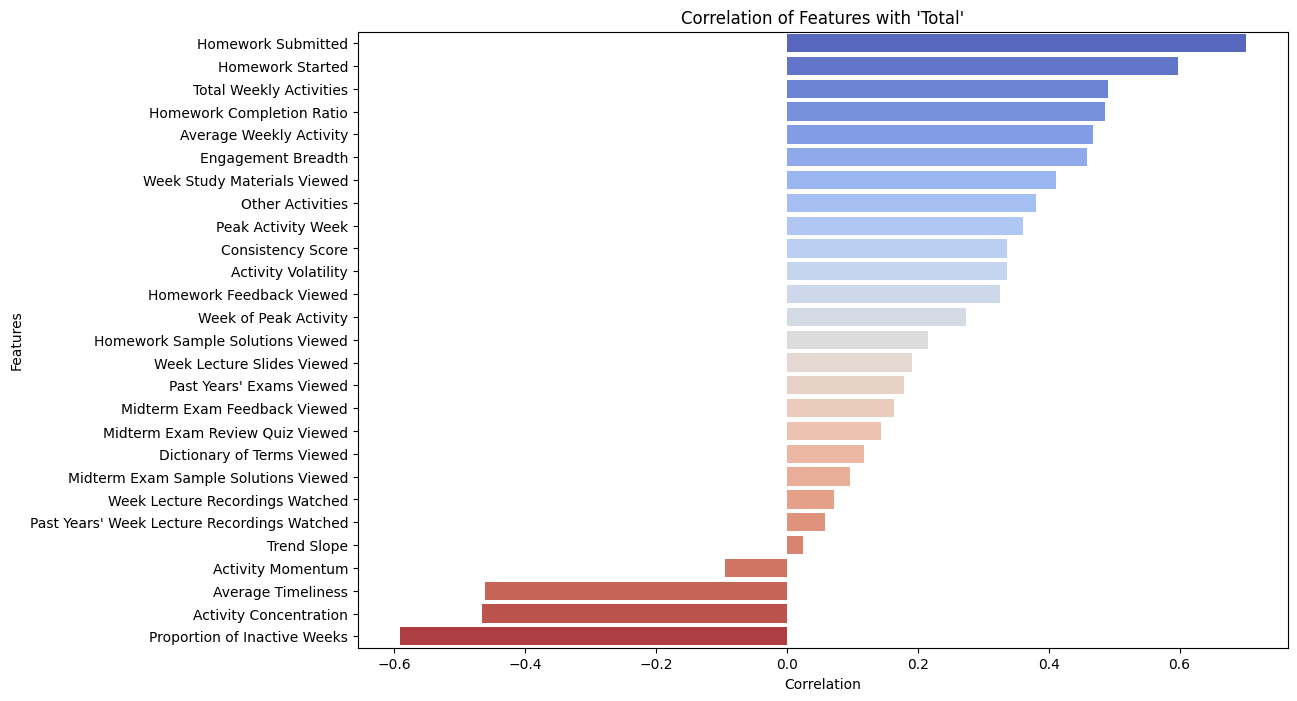

In [122]:
generate_total_correlation(logs)

Based on the correlation table, the best performing features with the most correlation to the **Total** feature are:

* **Homework Submitted**: 70%
* **Homework Started**: 60%
* **Proportion of Inactive Weeks**: -59%

An underwhelming result. Many of the features did not have as high of a correlation with **Total** as we hoped. Based on the top three performing features, we can weakly say that completing homework and consistently engaging with the course material has a weak correlation with a student's final grade.

### K-Means Visualization

Similarly to the correlation matrix, we can run k-means clustering to help visualize relationships between features. Again, we are most focused on the correlations with the **Total** feature.

Before visualizing, we need to determine an appropriate $k$. We run both the Elbow and Silhouette methods to find this.

In [123]:
def elbow_method(data, max_clusters=10):
    features = data.drop(columns=["Student", "Grade", "Total"])
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)
    
    # Run KMeans for different values of k
    wcss = []  # Within-Cluster Sum of Squares
    for k in range(1, max_clusters + 1):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(features_scaled)
        wcss.append(kmeans.inertia_)  # inertia_ is the WCSS
    
    # Plot
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, max_clusters + 1), wcss, marker='o', linestyle='--')
    plt.title("The Elbow Method")
    plt.xlabel("Number of Clusters (k)")
    plt.ylabel("WCSS (Within-Cluster Sum of Squares)")
    plt.grid()
    plt.show()

def silhouette_analysis(data, max_clusters=10):
    features = data.drop(columns=["Student", "Grade", "Total"])
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)
    
    silhouette_scores = []
    
    # Calculate silhouette score for different k values
    for k in range(2, max_clusters + 1):  # Start from k=2
        kmeans = KMeans(n_clusters=k, random_state=42)
        cluster_labels = kmeans.fit_predict(features_scaled)
        score = silhouette_score(features_scaled, cluster_labels)
        silhouette_scores.append(score)
        print(f"Silhouette Score for k={k}: {score:.4f}")
    
    # Plot
    plt.figure(figsize=(8, 5))
    plt.plot(range(2, max_clusters + 1), silhouette_scores, marker='o', linestyle='--')
    plt.title("Silhouette Scores for Different k")
    plt.xlabel("Number of Clusters (k)")
    plt.ylabel("Silhouette Score")
    plt.grid()
    plt.show()

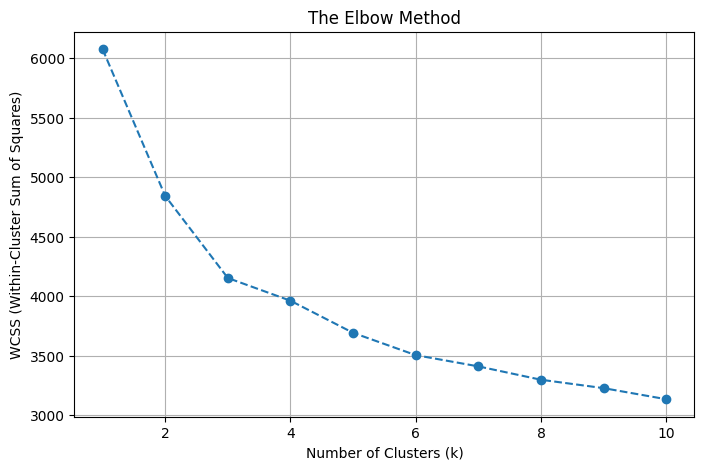

In [124]:
elbow_method(logs, max_clusters=10)

Silhouette Score for k=2: 0.2051
Silhouette Score for k=3: 0.2186
Silhouette Score for k=4: 0.2129
Silhouette Score for k=5: 0.1392
Silhouette Score for k=6: 0.1442
Silhouette Score for k=7: 0.1209
Silhouette Score for k=8: 0.0902
Silhouette Score for k=9: 0.1135
Silhouette Score for k=10: 0.0739


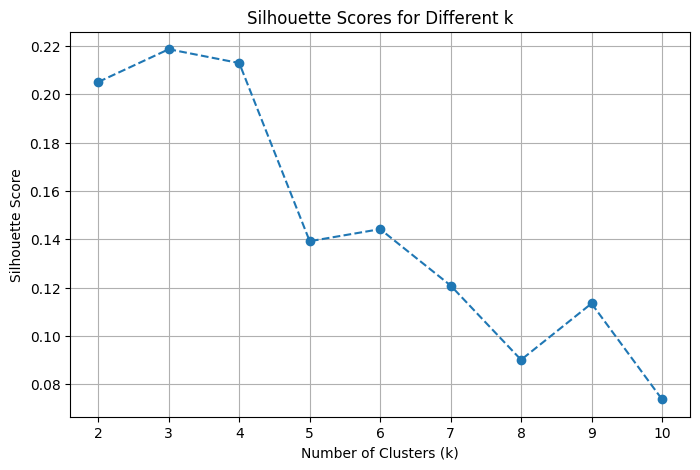

In [125]:
silhouette_analysis(logs, max_clusters=10)

We settle on $k=8$. We'll use PCA to reduce the dimensions to improve visualization.

In [126]:
def generate_cluster_scatterplots(data, num_clusters=8):
    features = data.drop(columns=["Student", "Grade", "Total"])
    target_feature = "Total"
    
    # Include "Total" in the features for clustering
    features_with_target = features.copy()
    features_with_target[target_feature] = data[target_feature]
    
    # Scale the features
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features_with_target)
    
    # K-Means
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    data["Cluster"] = kmeans.fit_predict(features_scaled)
    
    # Reduce dimensions to 2D using PCA
    pca = PCA(n_components=2)
    pca_components = pca.fit_transform(features_scaled)
    pca_df = pd.DataFrame(pca_components, columns=["PCA1", "PCA2"])
    pca_df["Cluster"] = data["Cluster"]
    
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x="PCA1", y="PCA2", hue="Cluster", palette="viridis", data=pca_df, s=100, marker="o", edgecolor="black")
    plt.title(f"KMeans Clustering (PCA) - {num_clusters} Clusters")
    plt.tight_layout()

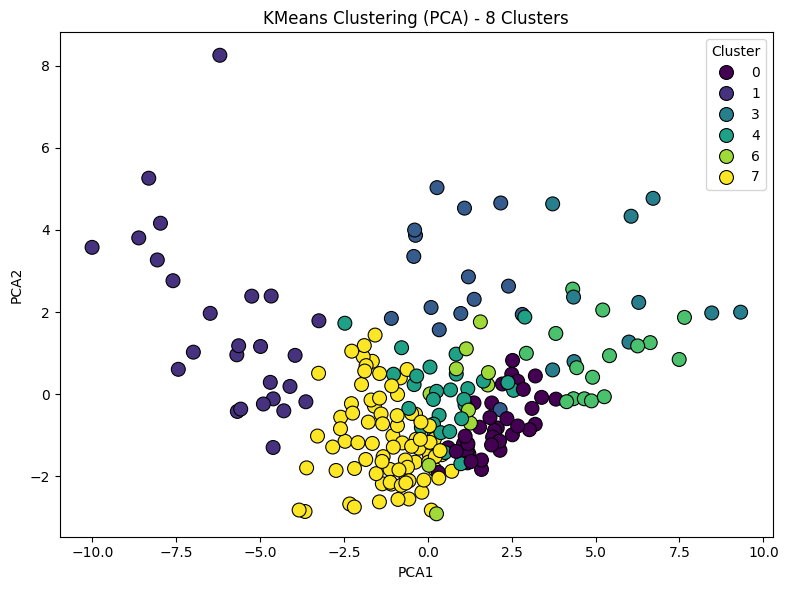

In [127]:
generate_cluster_scatterplots(logs)

It is difficult to draw conclusions from the **Final** plots. We see in the histogram for **Final** that that there is significant overlap between the 8 clusters.

### Random Forest Feature Evaluation

#### Feature Importance & Partial Dependence Plots

We can run our dataset through the Random Forest Regessor. After running, the regressor can tell us which features were most important in its tree decision making process. This can give us insight on which features the model values the most.

In [128]:
def feature_importance_ranking(data, target_column):
    data = data.select_dtypes(include=["number"])
    features = data.drop(columns=[target_column])
    target = data[target_column]

    # Scale features for uniformity
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)

    model = RandomForestRegressor()
    model.fit(features_scaled, target)

    importances = model.feature_importances_
    feature_names = features.columns
    importance_df = pd.DataFrame({"Feature": feature_names, "Importance": importances})
    importance_df = importance_df.sort_values(by="Importance", ascending=False)

    sns.barplot(x="Importance", y="Feature", data=importance_df)
    plt.title("Feature Importance")
    plt.show()

    # Plot PDPs for selected features
    PartialDependenceDisplay.from_estimator(
        model,
        features_scaled,
        features=[4, 6, 14], # Dictionary of Terms Viewed, Homework Submitted, Total Weekly Activities
        feature_names=features.columns,
        kind="average",
        n_jobs=-1,
    )
    plt.suptitle("Partial Dependence Plots for Random Forest Regressor", fontsize=16)
    plt.tight_layout()
    plt.show()

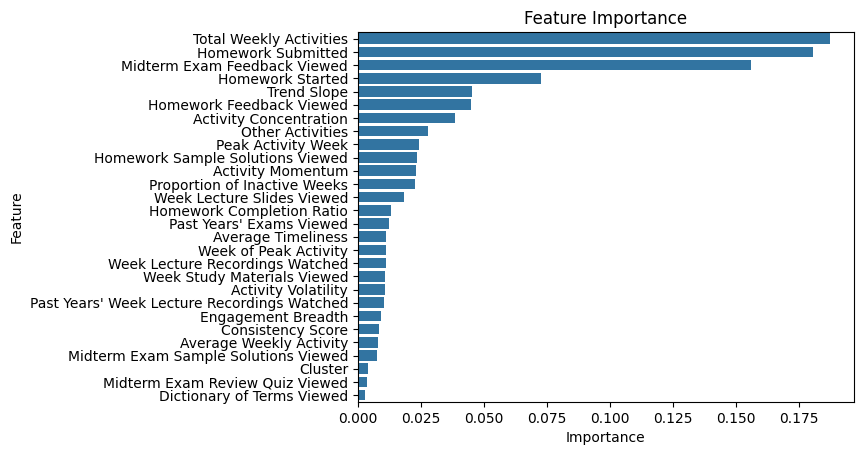

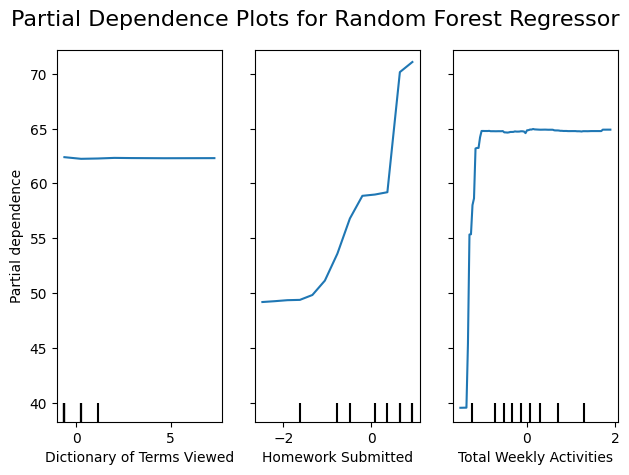

In [129]:
feature_importance_ranking(logs, "Total")

The Random Forest Regressor valued the **Total Weekly Activities** and **Homework Submitted** features the most, with the next tier of important features being viewing the **Midterm Exam Feedback** and **Homework Started**. Curiously, **Midterm Exam Feedback Viewed**, third-most-valued by the Regressor, had a low value of 16% in the correlation table.

Partial Dependence Plots are used to visualize the relationship between some feature and the target feature (in our case **Total**). We plot three features as an example. 

The first, the **Viewed Dictionary of Terms** feature. Both the correlation table and the Random Forest Regressor agree that with reguard to **Total**, it is an absolutely useless feature. The PDP confirms this as the horizontal line means that this feature has no effect on the model's prediction.

The second plotted and most valuable feature, **Homework Submitted** has a continuously increasing plot. This Indicates it has a strong positive relationship with  with **Total**.

The third plot, **Total Weekly Activities**, although the most valuable feature according to the regressor, sees deminishing returns after a certain point.

### Final Model Evaluation

#### Testing for Multicollinearity

Multicollinearity is when features are highly correlated with the target feature. This can hurt performance for linear models. We calculate the Variance Inflation Factor (VIF) to quantify multicollinearity within our dataset.

In [143]:
def calculate_vif(data, target_column="Total", max_vif=10):
    # Select numeric features, excluding target column
    features = data.select_dtypes(include=["number"]).drop(columns=[target_column], errors="ignore")
    features = features.loc[:, features.apply(lambda x: x.nunique() > 1)]

    # Don't drop Weekly Lecture Slides and Study Materials (Predicted correlation with Final)
    features = features.drop(columns="Week Lecture Slides Viewed", errors="ignore")
    features = features.drop(columns="Week Study Materials Viewed", errors="ignore")

    # Standardize features
    scaled_features = StandardScaler().fit_transform(features)
    # Calculate VIF for each feature
    vif_data = []
    for i, col in enumerate(features.columns):
        X = np.delete(scaled_features, i, axis=1)
        y = scaled_features[:, i]
        try:
            r_squared = LinearRegression().fit(X, y).score(X, y)
            vif = 1 / (1 - max(r_squared, 1e-4)) if max(r_squared, 1e-4) != 1 else 10
            vif_data.append({"Feature": col, "VIF": min(vif, max_vif)})
        except Exception as e:
            print(f"Error calculating VIF for {col}: {e}")
    # ID and drop high VIF features
    vif_df = pd.DataFrame(vif_data).sort_values(by="VIF", ascending=False)
    high_vif_features = vif_df[vif_df["VIF"] > 5]["Feature"].tolist()
    # Return VIF table and optionally return reduced dataset
    data_reduced = data.drop(columns=high_vif_features) if high_vif_features else data
    return vif_df, data_reduced

Let's see what the output looks like.

In [144]:
og_logs = logs.drop(columns=["Student", "Grade", "Cluster"], axis="columns")
vif_table, logs_clean_reduced = calculate_vif(og_logs)
print(vif_table)

                                        Feature        VIF
12                      Total Weekly Activities  10.000000
13                      Average Weekly Activity  10.000000
23                            Consistency Score  10.000000
4                            Homework Submitted  10.000000
16                          Activity Volatility  10.000000
14                           Peak Activity Week  10.000000
3                              Homework Started   8.072138
21                    Homework Completion Ratio   6.882936
19                       Activity Concentration   5.942245
17                 Proportion of Inactive Weeks   4.482392
22                           Engagement Breadth   3.634755
24                           Average Timeliness   2.496910
18                                  Trend Slope   2.447289
5              Homework Sample Solutions Viewed   2.352707
6                      Homework Feedback Viewed   2.308875
11                             Other Activities   2.1752

#### Random Forest Over Compressed vs Uncompressed Dimensionality

If we drop all the features with a high VIF ($\text{VIF} > 5$) with some exceptions, we are left with a smaller dimensional dataset. Let's now run that Random Forest Regressor with a little more formality this time over this new compressed dataset.

In [148]:
def train_evaluate_random_forest(logs, target_column="Total", test_size=0.2, random_state=42):
    # Split features/target
    X = logs.drop(columns=[target_column], errors="ignore")
    y = logs[target_column]

    # Split training/testing
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # Train RFR
    model = RandomForestRegressor(random_state=random_state)
    model.fit(X_train, y_train)

    # Predict
    y_pred = model.predict(X_test)

    # Eval model
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    return {
        "mse": mse,
        "r2": r2
    }

In [149]:
vif_results = train_evaluate_random_forest(logs_clean_reduced)
print(f"Mean Squared Error: {vif_results["mse"]:.2f}")
print(f"R^2 Score: {vif_results["r2"]:.2f}")

Mean Squared Error: 256.41
R^2 Score: 0.54


Not a terribe score. Let's run it again, this time over the original 27 dimensional dataset to see if this dimensional compression was worth it.

In [150]:
og_logs = logs.drop(columns=["Student", "Grade"], axis="columns")
vif_results = train_evaluate_random_forest(og_logs)
print(f"Mean Squared Error: {vif_results['mse']:.2f}")
print(f"R^2 Score: {vif_results['r2']:.2f}")

Mean Squared Error: 313.37
R^2 Score: 0.44


Looks like it was worth it to de-dimensionalize. Removing features that had high VIF scores reduced the "clutter" within the dataset and allowed the model to produce improved results.

#### A Final Hail Mary: XGBoost & Lasso

Let's see how much performance we can juice out of this dataset. Let's implement some XGBoost and Lasso models, run it over the original dataset, and see what happens.

In [151]:
def train_evaluate_lasso(logs, target_column="Total", test_size=0.2, random_state=42):
    # Split features/target
    X = logs.drop(columns=[target_column], errors="ignore")
    y = logs[target_column]
    
    # Split training/testing
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    
    # Lasso
    lasso = Lasso(random_state=random_state, max_iter=10000)
    lasso_params = {"alpha": [0.01, 0.1, 1.0, 10.0]}
    lasso_grid = GridSearchCV(estimator=lasso, param_grid=lasso_params, cv=5, scoring='r2', n_jobs=-1)
    lasso_grid.fit(X_train, y_train)
    lasso_best = lasso_grid.best_estimator_
    lasso_pred = lasso_best.predict(X_test)
    mse = mean_squared_error(y_test, lasso_pred)
    r2 = r2_score(y_test, lasso_pred)
    return {
        "mse": mse,
        "r2": r2
    }

def train_evaluate_xgboost(logs, target_column="Total", test_size=0.2, random_state=42):
    # Split features/target
    X = logs.drop(columns=[target_column], errors="ignore")
    y = logs[target_column]

    # Split training/testing
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    xgb = XGBRegressor(random_state=random_state)
    xgb_params = {
        "n_estimators": [50, 100, 200],
        "learning_rate": [0.01, 0.1, 0.2],
        "max_depth": [3, 5, 7],
        "subsample": [0.8, 1.0],
        "colsample_bytree": [0.8, 1.0]
    }
    xgb_grid = GridSearchCV(estimator=xgb, param_grid=xgb_params, cv=5, scoring='r2', n_jobs=-1)
    xgb_grid.fit(X_train, y_train)
    xgb_best = xgb_grid.best_estimator_
    xgb_pred = xgb_best.predict(X_test)
    mse = mean_squared_error(y_test, xgb_pred)
    r2 = r2_score(y_test, xgb_pred)

    return {
        "mse": mse,
        "r2": r2
    }

In [155]:
og_logs = logs.drop(columns=["Student", "Grade", "Cluster"], axis="columns")
xg = train_evaluate_xgboost(logs_clean_reduced)
print(f"XGBoost (D) Mean Squared Error: {xg["mse"]:.2f}")
print(f"XGBoost (D) R^2 Score: {xg["r2"]:.2f}")

lasso = train_evaluate_lasso(logs_clean_reduced)
print(f"Lasso (D) Mean Squared Error: {lasso["mse"]:.2f}")
print(f"Lasso (D) R^2 Score: {lasso["r2"]:.2f}")

og_logs = logs.drop(columns=["Student", "Grade", "Cluster"], axis="columns")
xg = train_evaluate_xgboost(og_logs)
print(f"XGBoost Mean Squared Error: {xg["mse"]:.2f}")
print(f"XGBoost R^2 Score: {xg["r2"]:.2f}")

lasso = train_evaluate_lasso(og_logs)
print(f"Lasso Mean Squared Error: {lasso["mse"]:.2f}")
print(f"Lasso R^2 Score: {lasso["r2"]:.2f}")

XGBoost (D) Mean Squared Error: 308.73
XGBoost (D) R^2 Score: 0.45
Lasso (D) Mean Squared Error: 387.11
Lasso (D) R^2 Score: 0.31
XGBoost Mean Squared Error: 380.85
XGBoost R^2 Score: 0.32
Lasso Mean Squared Error: 332.60
Lasso R^2 Score: 0.41


/Users/kaljunekvasil/.pyenv/versions/ml-bulk/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.326e+02, tolerance: 1.067e+01
  model = cd_fast.enet_coordinate_descent(
/Users/kaljunekvasil/.pyenv/versions/ml-bulk/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.294e+03, tolerance: 1.056e+01
  model = cd_fast.enet_coordinate_descent(
/Users/kaljunekvasil/.pyenv/versions/ml-bulk/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the 

XGBoost improved performance after de-dimensionalization but Lasso performance decreased. This could be because XGBoost benefited from less cluttered or redundant data, adding clarity within its tree structure. Lasso relies on L1 regularization, and could have been more negatively affected by the removal of features.

## Conclusion

Our goal is to identify student activities or behavioural patterns that correlate with successful grades. We use methods ranging from creating new features, correlation matrices, K-means for visualization, feature selection using a Random Forest model, and evaluating prediction accuracy for the ensemble models Random Forest, XGBoost, and Lasso.

The results were dubious for all ensemble models, with the best reporting an $R^{2} = 0.54$. Basic correlation relationships between all features and **Total** were were also unconvincing with the highest correlation being $70\%$.

After concluding with analysis, the behaviors that the team can best correlate with successful grades can be best summarized as: "Do your homework, consistently study the course material every week, and read the feedback on your midterm exam."

Having only 2 semesters and just over 200 students woth of data was a limiting factor. Perhaps more conclusive results could have been made with more semesters worth of data. 
It is also possible that there exists undiscovered features that have high correlation with **Final** and the team just lacked the creativity to see them.